# I-STL Overview 

- Add a brief description here

### 1. Read in Data 

- `lat_n and lon_n` correspond to the latitude and longitude lists of agent n for plotting 
- `t` is the timestep array 
- `x_n` is the signal for agent n that we will use to compute robustness 
    - In this example, `x_n` is a numpy array of size (t, 2) that consists of t rows of [lat_n, lon_n] @ time t

In [130]:
import numpy as np
import sympy as sp
import time
import interval
from inclusion import NaturalInclusionFunction
import matplotlib.animation as animation
from scipy.io import loadmat
from stlpy.STL import LinearPredicate, NonlinearPredicate
from matplotlib import pyplot as plt
from matplotlib import rc
import pickle 

rc('text', usetex=True)

# Part 1: Un-pickling and loading MITLL data 
with open('sim_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Get all the GCS values for agent 1 

lat_1 = []
lon_1 = []
alt_1 = []

# And agent 4 
lat_4 = []
lon_4 = []
alt_4 = []

# Signal and time lists 
x1 = [] 
x4 = []
t = []

# There is definitely a better way to go about doing this with fewer lines 
for timestamp in data:

    # Original code sets up all agents in case we want to build on specs (i.e. don't crash, etc.)
    t.append(timestamp[0]) 
    lat_1.append(timestamp[1][1]["lat"])
    lon_1.append(timestamp[1][1]["lon"])
    x1.append([timestamp[1][1]["lat"], timestamp[1][1]["lon"]])

    lat_4.append(timestamp[1][4]["lat"])
    lon_4.append(timestamp[1][4]["lon"])
    x4.append([timestamp[1][4]["lat"], timestamp[1][4]["lon"]])

# Our signal- just lat and lon position 
t = np.array(t)
x1 = np.array(x1)
x4 = np.array(x4)
print(x1.shape)
print(x4.shape)
print(t.shape)
nt = t.shape[0]



(1800, 2)
(1800, 2)
(1800,)


### 2. Set Up the Specification

- In this case we want the agent's position to fall within the bounding box specified below within a certain timestep interval.
- Bounding box manually set by identifying center point of [lat, lon] close to where the agent passes through and applying +- offset in each direction. 
    - This example uses a center point of [42.49464, -71.6734] and offset of +- 0.0003 

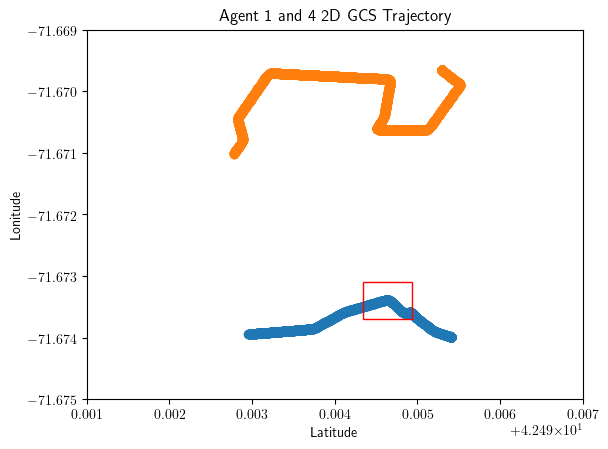

In [131]:
offset = 0.0003
lat_center = 42.49464
lon_center = -71.6734

# 2D Trajectory Plot
plt.figure()
plt.title("Agent 1 and 4 2D GCS Trajectory")
plt.xlabel("Latitude")
plt.ylabel("Lonitude")

square = plt.Rectangle((lat_center - offset, lon_center - offset), 2*offset, 2*offset, facecolor='none', ec="red")
plt.gca().add_patch(square)
plt.xlim([42.491, 42.497])
plt.ylim([-71.675, -71.669])
plt.scatter(lat_1, lon_1)
plt.scatter(lat_4, lon_4)
plt.show()


Now to set up the bounding box specification: 

1. Specify the agent position requirements: 

    1. $p_{lat} > c_{lat} - offset $ --> `left`
    2. $p_{lat} < c_{lat} + offset $ --> `right`
    3. $p_{lon} >  c_{lon} - offset $ --> `bottom`
    4. $p_{lon} < c_{lon} + offset $  --> `top`     
    <br></br>
2. Using the inequality for a linear predicate, reformat the inequalities above to be constructed into `LinearPredicate` objects

    $a^Ty_t - b \geqq 0$

    where: 

    - $y_t $ is the value of our signal at timestep t
    - $a^T $ is a numpy array or list representing vector a (needs to be the same dimension as the signal)
        - In our case we will use it to zero out the signal values we don't need 
    - $b $ will be the position bound 

    Example for position requirement 1 (`left` in the code):  $p_{lat} > c_{lat} - offset $ 
    
    $ \begin{bmatrix}1\\0\end{bmatrix} * \begin{bmatrix} p_{lat_t}&&p_{lon_t} \end{bmatrix} - (c_{lat} - offset) \geqq 0$

    where: 

    - $y_t  = \begin{bmatrix} p_{lat_t}&&p_{lon_t} \end{bmatrix}$
    - $a^T  = \begin{bmatrix}1\\0\end{bmatrix}$
    - $b  = (c_{lat} - offset)$
<br></br>
3. Set up the specification (with predicates `left, right, top, bottom`) with $\land$ since we want it inside the box

    $ \pi  = \diamond_{[t_1, t_2]}(left \land right \land top \land bottom )$



In [132]:
a_lat = np.array([1,0]) # Set up the a matrices 
a_long = np.array([0,1])

left = LinearPredicate(a_lat, lat_center - offset) 
right = LinearPredicate(-a_lat, -lat_center - offset) 
top = LinearPredicate(-a_long, -lon_center - offset)
bottom = LinearPredicate(a_long, lon_center - offset)


square_spec = left & right & top & bottom

# Times determined manually - I might change this in the future
pi = square_spec.always(513, 582)

## 3. Set up the Interval Analysis 

Create an array with the uncertainty for each signal variable.


In [133]:
# Create an uncertainty for each of the values.
eps = np.array([0.0000005, 0.0000005]) #* 10 
epsilon = interval.get_iarray(-1*eps, eps)

x1_no_uncertainty = x1.copy()
x1 = x1 + epsilon # Add uncertainty to the signal. For a "no uncertainty" version, comment this line.
x4_no_uncertainty = x4.copy()
x4 = x4 + epsilon


## 4. Compute the Robustness Vector
We can also set up the spec to evaluate relatively as well- this might be a good way to handle online trace monitoring. 

In [134]:
rho1 = []
rho4 = []
robustness_start_time = time.time() # For reporting the computation time.

for j in range(nt):
    rho1.append(pi.robustness((x1.T), 0)) 
    rho4.append(pi.robustness((x4.T), 0)) 

print("--- Robustness computation took %s seconds ---" % (time.time() - robustness_start_time))
nt1 = len(rho1)
rho1 = np.array(rho1)
nt4 = len(rho4)
rho4 = np.array(rho4)

--- Robustness computation took 6.382872819900513 seconds ---


## 5. Plot 

Agent 1 is blue, 4 is red. 

In this case, the robustness value will be constant as it's evaluated over the entre signal. Since only agent 1 fulfills the specification, it will have a positive value. 

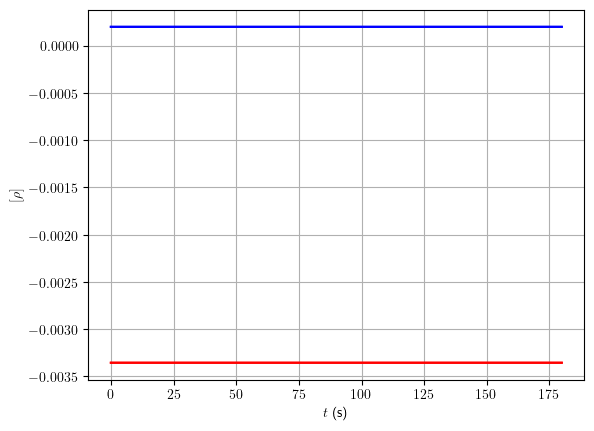

In [135]:
# For plotting, convert rho back to two values
_rho1, rho1_ = interval.get_lu(rho1)
_rho4, rho4_ = interval.get_lu(rho4)

rho_fig, rho_axes = plt.subplots()
rho_axes.ticklabel_format(useOffset=False, style='plain')
rho_fig.subplots_adjust()
rho_axes.plot(t,  _rho1, 'b')
rho_axes.plot(t, rho1_, 'b')
rho_axes.fill_between(t, _rho1, rho1_, facecolor='b', alpha=.25)
rho_axes.plot(t,  _rho4, 'r')
rho_axes.plot(t, rho4_, 'r')
rho_axes.fill_between(t, _rho4, rho4_, facecolor='r', alpha=.25)
rho_axes.set_ylabel('$[\\rho]$')
rho_axes.set_xlabel('$t$ (s)')
rho_axes.grid(True)